# module 1 - homework

[homework problems](https://github.com/DataTalksClub/mlops-zoomcamp/blob/main/cohorts/2024/01-intro/homework.md)

## imports

In [1]:
import pandas as pd

from sklearn.feature_extraction import DictVectorizer

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error

In [2]:
import seaborn as sns

In [3]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

## Q1 - download the data
We'll use the same NYC taxi dataset, but instead of "Green Taxi Trip Records", we'll use "Yellow Taxi Trip Records". Download the data for January and February 2023.

Read the data for January. How many columns are there?

**Answer**: 19

In [4]:
df_jan = pd.read_parquet('../data/yellow_tripdata_2023-01.parquet')

In [5]:
df_jan.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'airport_fee'],
      dtype='object')

In [6]:
df_jan.shape

(3066766, 19)

## Q2 - computing duration

Now let's compute the duration variable. It should contain the duration of a ride in minutes.

What's the standard deviation of the trips duration in January?

**Answer:** 42.59

In [7]:
# creates an object Timedelta of dtype '<m8[us]'
df_jan['duration'] = df_jan['tpep_dropoff_datetime'] - df_jan['tpep_pickup_datetime']

df_jan.duration.head()

0   0 days 00:08:26
1   0 days 00:06:19
2   0 days 00:12:45
3   0 days 00:09:37
4   0 days 00:10:50
Name: duration, dtype: timedelta64[us]

In [8]:
df_jan.duration.dtype

dtype('<m8[us]')

In [9]:
df_jan.duration[0]

Timedelta('0 days 00:08:26')

In [10]:
df_jan.duration[0].total_seconds()

506.0

In [11]:
# convert duration to minutes
df_jan.duration = df_jan.duration.apply(lambda td: td.total_seconds() / 60)

In [12]:
df_jan.duration.std()

42.59435124195458

## Q3 - dropping outliers

Next, we need to check the distribution of the duration variable. There are some outliers. Let's remove them and keep only the records where the duration was between 1 and 60 minutes (inclusive).

What fraction of the records left after you dropped the outliers?

**Answer:** 98%

/var/folders/jf/vw7y3m5s06g4gmn06dj1m0x80000gn/T/ipykernel_16036/1995654764.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_jan.duration)


<Axes: xlabel='duration', ylabel='Density'>

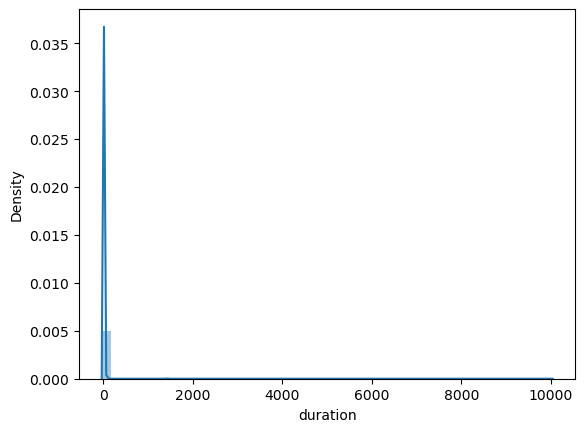

In [13]:
sns.distplot(df_jan.duration)

In [14]:
df_jan.duration.describe(percentiles=[0.95, 0.98, 0.99])

count    3.066766e+06
mean     1.566900e+01
std      4.259435e+01
min     -2.920000e+01
50%      1.151667e+01
95%      3.646667e+01
98%      4.873333e+01
99%      5.725000e+01
max      1.002918e+04
Name: duration, dtype: float64

In [15]:
# df = df[(df.duration >= 1) & (df.duration <= 60)]
df_jan = df_jan[(df_jan.duration >= 1) & (df_jan.duration <= 60)]
df_jan.shape

(3009173, 20)

In [16]:
# percentage of records kept
(3009173 / 3066766) * 100

98.1220282212598

## Q4 - one-hot encoding
Let's apply one-hot encoding to the pickup and dropoff location IDs. We'll use only these two features for our model.

Turn the dataframe into a list of dictionaries (remember to re-cast the ids to strings - otherwise it will label encode them)
- Fit a dictionary vectorizer
- Get a feature matrix from it
- What's the dimensionality of this matrix (number of columns)?

**Answer:** 515

In [17]:
categorical = ['PULocationID', 'DOLocationID']
df_jan[categorical].dtypes

PULocationID    int64
DOLocationID    int64
dtype: object

In [18]:
# one-hot encoding requires str data type
df_jan[categorical] = df_jan[categorical].astype(str)
df_jan.shape

(3009173, 20)

In [19]:
# turn df to list of dictionaries
df_jan[categorical].iloc[:10].to_dict(orient='records')

[{'PULocationID': '161', 'DOLocationID': '141'},
 {'PULocationID': '43', 'DOLocationID': '237'},
 {'PULocationID': '48', 'DOLocationID': '238'},
 {'PULocationID': '138', 'DOLocationID': '7'},
 {'PULocationID': '107', 'DOLocationID': '79'},
 {'PULocationID': '161', 'DOLocationID': '137'},
 {'PULocationID': '239', 'DOLocationID': '143'},
 {'PULocationID': '142', 'DOLocationID': '200'},
 {'PULocationID': '164', 'DOLocationID': '236'},
 {'PULocationID': '141', 'DOLocationID': '107'}]

In [20]:
train_dicts = df_jan[categorical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)
X_train

<3009173x515 sparse matrix of type '<class 'numpy.float64'>'
	with 6018346 stored elements in Compressed Sparse Row format>

In [21]:
df_jan[categorical].count()

PULocationID    3009173
DOLocationID    3009173
dtype: int64

In [22]:
# 255 + 260 = 515
df_jan[categorical].nunique()

PULocationID    255
DOLocationID    260
dtype: int64

## Q5 - training a model, rmse on train
Now let's use the feature matrix from the previous step to train a model.

Train a plain linear regression model with default parameters.  
Calculate the RMSE of the model on the training data.  
What's the RMSE on train?  

**Answer:** 7.64

In [23]:
df_jan['duration'].head()

0     8.433333
1     6.316667
2    12.750000
3     9.616667
4    10.833333
Name: duration, dtype: float64

In [24]:
target = 'duration'
y_train = df_jan[target].values
y_train

array([ 8.43333333,  6.31666667, 12.75      , ..., 24.51666667,
       13.        , 14.4       ])

In [25]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

/usr/local/Caskroom/miniconda/base/envs/mlopszoomcamp/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


7.649261934850555

In [26]:
# double check new function
root_mean_squared_error(y_train, y_pred)

7.649261934850555

## Q6 - evaluating the model, rmse on validation
Now let's apply this model to the validation dataset (February 2023).

What's the RMSE on validation?

**Answer:** 7.81

In [27]:
df_feb = read_dataframe('../data/yellow_tripdata_2023-02.parquet')
df_feb.shape

(2855951, 20)

In [28]:
df_feb.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'Airport_fee', 'duration'],
      dtype='object')

In [29]:
df_feb.duration.describe(percentiles=[0.95, 0.98, 0.99])

count    2.855951e+06
mean     1.446811e+01
std      1.006423e+01
min      1.000000e+00
50%      1.181667e+01
95%      3.521667e+01
98%      4.503333e+01
99%      5.071667e+01
max      6.000000e+01
Name: duration, dtype: float64

In [30]:
# df = df[(df.duration >= 1) & (df.duration <= 60)]
df_feb = df_feb[(df_jan.duration >= 1) & (df_feb.duration <= 60)]
df_feb.shape

/var/folders/jf/vw7y3m5s06g4gmn06dj1m0x80000gn/T/ipykernel_16036/2345825633.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_feb = df_feb[(df_jan.duration >= 1) & (df_feb.duration <= 60)]


(2801664, 20)

In [31]:
# percentage of data kept
(2801664 / 2855951) * 100

98.0991620654556

In [32]:
df_feb[categorical].dtypes

PULocationID    object
DOLocationID    object
dtype: object

In [33]:
val_dicts = df_feb[categorical].to_dict(orient='records')

X_val = dv.transform(val_dicts)
X_val

<2801664x515 sparse matrix of type '<class 'numpy.float64'>'
	with 5603320 stored elements in Compressed Sparse Row format>

In [34]:
y_val = df_feb[target].values
y_val

array([ 1.68333333, 32.08333333, 13.3       , ..., 14.        ,
        7.        ,  9.8       ])

In [35]:
y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)

7.811286891714771